In [1]:
import numpy as np
import copy
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

In [2]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_lima') # type here hardware backend  

In [3]:
from scipy.optimize import curve_fit

In [4]:
def retrieve_from_lsf(exp):
    perr_fm = np.sqrt(np.diag(exp._analysis_results[0]['pcov']))
    popt_fm = exp._analysis_results[0]['popt']
    epc_est_fm = exp._analysis_results[0]['EPC']
    epc_est_fm_err = exp._analysis_results[0]['EPC_err']
    experiment_type = exp._data[0]['metadata']['experiment_type']
    return perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type

In [6]:
def get_GSP_counts(data, x_length, data_range):
#obtain the observed counts used in the bayesian model
#corrected for accomodation pooled data from 1Q, 2Q and 3Q interleave processes
    list_bitstring = ['0','00', '000', '100'] # all valid bistrings
    Y_list = []
    for i_samples in data_range:
        row_list = []
        for c_index in range(x_length) :  
            total_counts = 0
            i_data = i_samples*x_length + c_index
            for key,val in data[i_data]['counts'].items():
                if  key in list_bitstring:
                    total_counts += val
            row_list.append(total_counts)
        Y_list.append(row_list)    
    return np.array(Y_list)

# Running 1-qubit RB

In [7]:
lengths = np.arange(1, 1000, 100)
num_samples = 10 
#seed = 1010 no seed
qubits = [0]

physical_qubits = [0]
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate =''

In [8]:
len(lengths)*num_samples

100

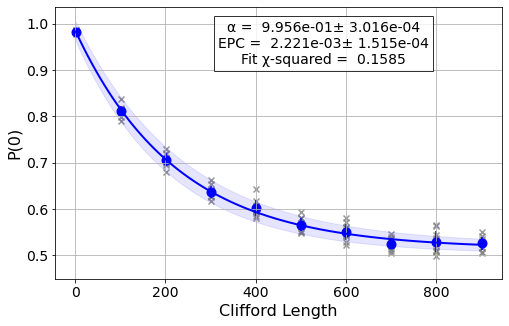

In [9]:
# Run an RB experiment on a single qubit
exp1 = rb.StandardRB(qubits, lengths, num_samples=num_samples)
expdata1 = exp1.run(backend)

In [10]:
print(expdata1)

---------------------------------------------------
Experiment: StandardRB
Experiment ID: b3a24254-1cb8-4604-b83b-b5c8a21eeb03
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47134237186253947 ± 0.010360533410602757
- alpha: 0.995558778230167 ± 0.00030156493958346836
- b: 0.5139770035514991 ± 0.010233385469253876
- analysis_type: RBAnalysis
- reduced_chisq: 0.1585155531825948
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.002220610884916485
- EPC_err: 0.0001514551155480588
- EPG: {0: {'rz': 0.0, 'sx': 0.00045152693551006335, 'x': 0.00045152693551006335}}
- success: True


In [11]:
# backend's recorded EPG
print(rb.RBUtils.get_error_dict_from_backend(backend, qubits))

{((0,), 'id'): 0.0004432101747785104, ((0,), 'rz'): 0, ((0,), 'sx'): 0.0004432101747785104, ((0,), 'x'): 0.0004432101747785104}


In [12]:
# retrieve LSF fitter results from qiskit experiments (_ex) analysis
perr_ex, popt_ex, epc_ex, epc_ex_err, experiment_type = retrieve_from_lsf(expdata1)
alpha_ex = popt_ex[1] 
alpha_ex_err = perr_ex[1]
A_ex = popt_ex[0] 
A_ex_err = perr_ex[0] 
B_ex = popt_ex[2] 
B_ex_err = perr_ex[2]

In [13]:
# direct scipy (_sc) LSF 
# get count data and retrieve shots number
Y = get_GSP_counts(expdata1._data, len(lengths),range(num_samples))
shots = sum(expdata1._data[0]['counts'].values())
print("shots:", shots)

shots: 1024


In [18]:
# function to optimize
def lsf(x, a, alpha, b):
    return a * alpha ** x + b
# curve fit
popt_sc,pcov_sc = curve_fit(lsf, np.array(num_samples*list(lengths)),
                          np.ravel(Y)/shots, maxfev = 10000,
                          bounds = ([(1. - scale)/2,.9,(1. - scale)/2],[scale*3/2,1.0,scale*3/2]))
                                
perr_sc= np.sqrt(np.diag(pcov_sc))
# get EPC and EPC sigma for LSF accelerated
alpha_sc = popt_sc[1] 
alpha_sc_err = perr_sc[1] 
A_sc = popt_sc[0] 
A_sc_err = perr_sc[0] 
B_sc = popt_sc[2] 
B_sc_err = perr_sc[2]
epc_sc = scale*(1 - alpha_sc)
epc_sc_err = scale*alpha_sc_err

In [19]:
# compare ex and sc
# bounds = ([(1. - scale)/2,.9,(1. - scale)/2],[scale*3/2,1.0,scale*3/2])        
print("       Qiskit experiments  Scipy direct")
print("_______________________________________")
print("A          {0:1.3e}        {1:1.3e} "
      .format(A_ex,A_sc)) 
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(A_ex_err, A_sc_err))
print("B          {0:1.3e}        {1:1.3e} "
      .format(B_ex,B_sc))
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(B_ex_err, B_sc_err))
print("alpha      {0:1.3e}        {1:1.3e} "
      .format(alpha_ex,alpha_sc))
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(alpha_ex_err, alpha_sc_err))
print("EPC         {0:1.3e}        {1:1.3e} "
      .format(epc_ex,epc_sc))  
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_ex_err, epc_sc_err))


       Qiskit experiments  Scipy direct
_______________________________________
A          4.713e-01        4.689e-01 
± sigma    ± 1.036e-02      ± 5.112e-03 
B          5.140e-01        5.147e-01 
± sigma    ± 1.023e-02      ± 3.553e-03 
alpha      9.956e-01        9.956e-01 
± sigma    ± 3.016e-04      ± 1.251e-04 
EPC         2.221e-03        2.204e-03 
± sigma    ± 1.515e-04      ± 6.256e-05 
